# Mapping Overdose Vulnerability
## Andy Asher, NWMSU
### https://github.com/andyakiva/capstone

Import the cleaned data and the needed packages

In [18]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
csv = r'C:\Users\Andy\Documents\OverdoseAnalysis\ReadyData.csv'
data = pd.read_csv(csv)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 20 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Zip Code                           51 non-null     int64  
 1   Males Widowed                      51 non-null     float64
 2   Males Divorced                     51 non-null     float64
 3   Females Widowed                    51 non-null     float64
 4   Females Divorced                   51 non-null     float64
 5   High school graduate or higher     51 non-null     float64
 6   Bachelor's degree or higher        51 non-null     float64
 7   Civilian veterans                  51 non-null     float64
 8   With a disability                  51 non-null     float64
 9   Unemployment Rate                  51 non-null     float64
 10  With health insurance coverage     51 non-null     float64
 11   With private health insurance     51 non-null     float64
 

Define Column Names

In [19]:
data.columns = ["Zip Code", "Males Widowed", "Males Divorced", "Females Widowed", "Females Divorced", "High school graduate or higher", 
                "Bachelor's degree or higher", "Civilian veterans", "With a disability", "Unemployment Rate", "With health insurance coverage",
                "With private health insurance", "With public coverage", "No health insurance coverage",
                "Percent People in Poverty", "Median household income (dollars)", "Mean household income (dollars)", "FATAL OVERDOSE BY ZIP CODE","Males 15 Years and Over", "Females 15 Years and Over"]
data = data.set_index("Zip Code")


Convert Overdose Count to Rate Per Capita

In [20]:
data["Overdose per capita"] = data["FATAL OVERDOSE BY ZIP CODE"] / ((data["Males 15 Years and Over"]+ data["Females 15 Years and Over"])/1000)

Preliminary Visualizations

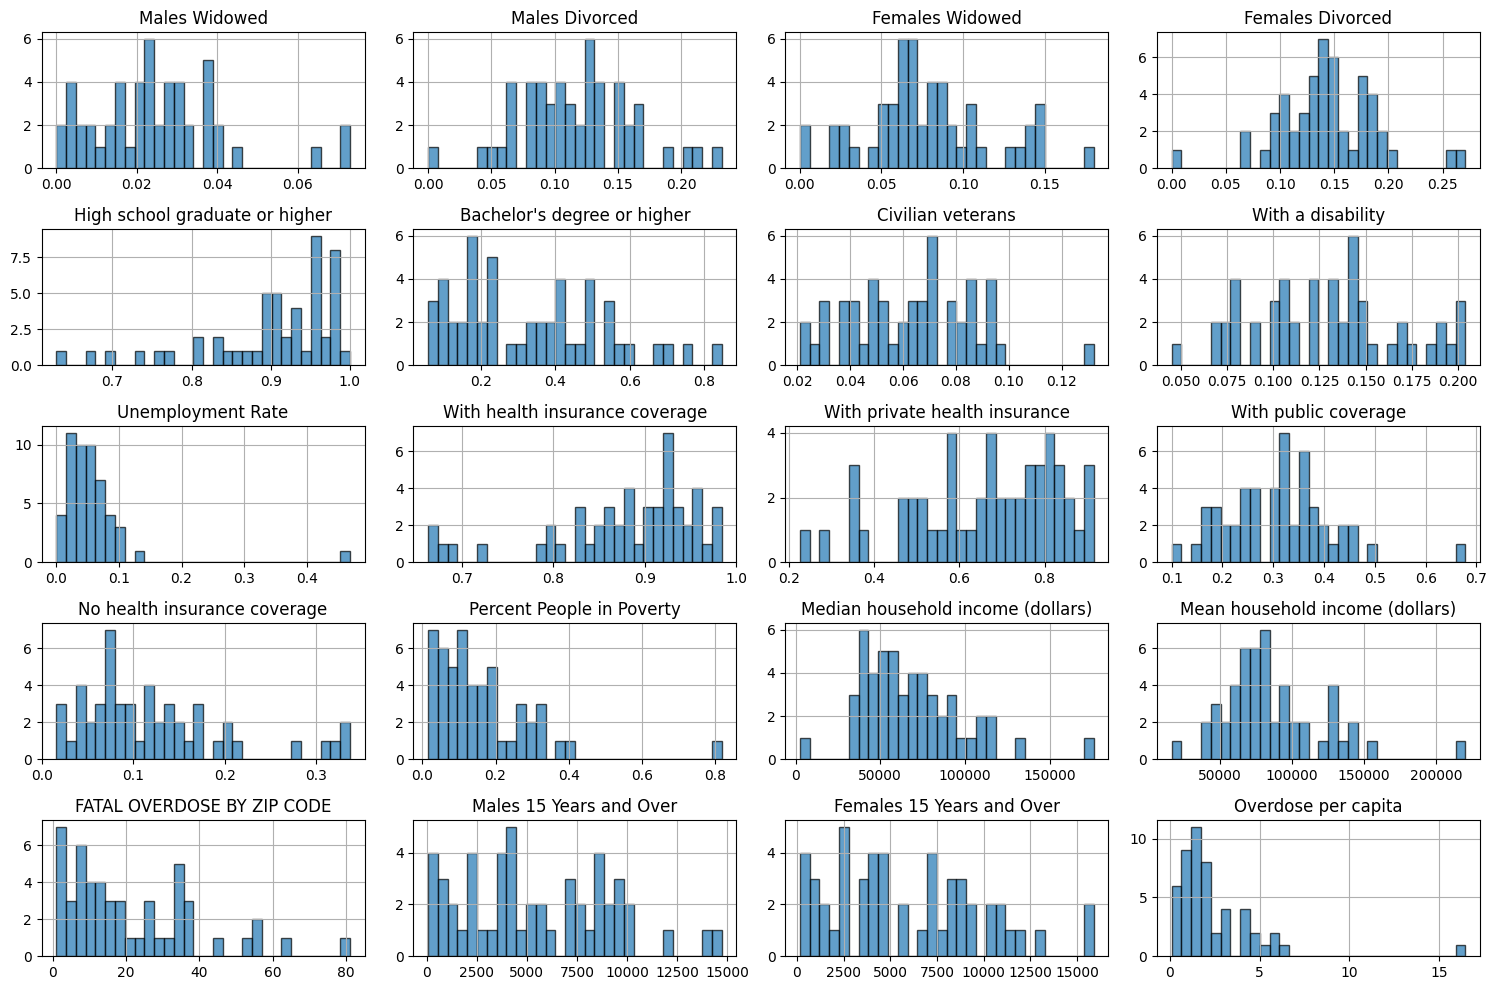

In [21]:
data.hist(figsize=(15, 10), bins=30, edgecolor='k', alpha=0.7)
plt.tight_layout()
plt.show()

Initial Correlation Overview

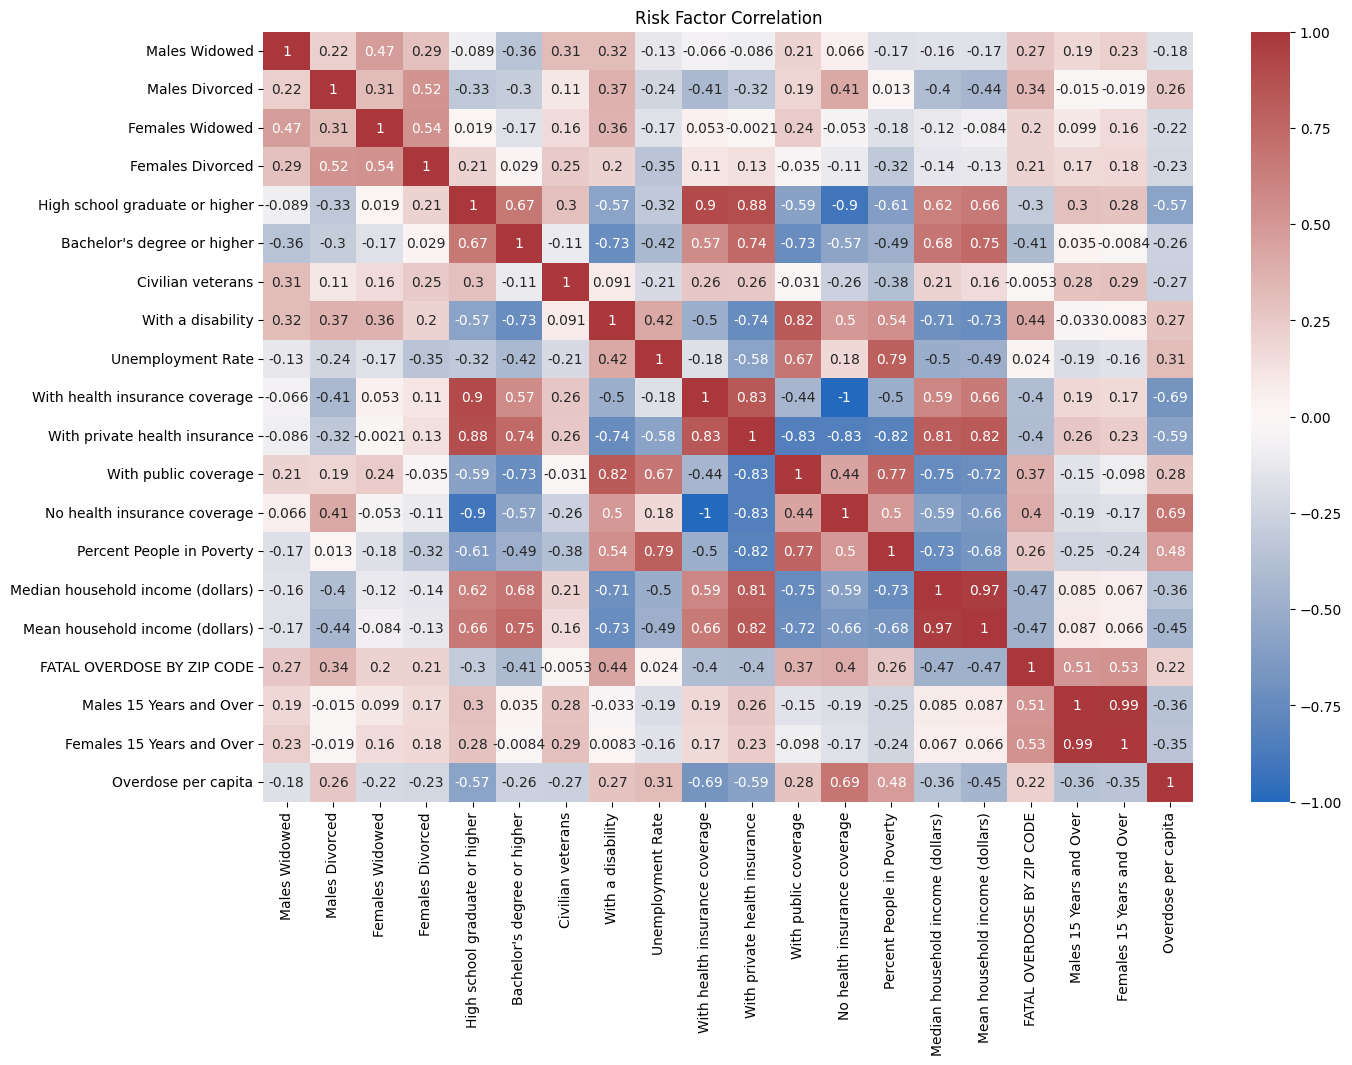

In [117]:
correlation = data.corr()
plt.figure(figsize=(15, 10))
sns.heatmap(correlation, annot=True, cmap="vlag")
plt.title('Risk Factor Correlation')
plt.show()

## ML 

Train Test Split

In [148]:
import sklearn
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(data,
 test_size=0.25, random_state=123)
print('Train size: ', len(train_set), 'Test size: ', len(test_set))

Train size:  38 Test size:  13


In [149]:
test1 = "With private health insurance"
test2 = "With public coverage"
test3 = "High school graduate or higher"
overdoses = "Overdose per capita"

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
X = train_set[[test1, test2, test3]]
y = train_set[overdoses]
X_test = test_set[[test1, test2, test3]]
y_test = test_set[overdoses]
lr_model = LinearRegression()
lr_model.fit(X,y)
y_pred = lr_model.predict(X)
print('Results for linear regression on training data')
print(' Default settings')
print('Internal parameters:')
print(' Bias is ', lr_model.intercept_)
print(' Coefficients', lr_model.coef_)
print(' Score', lr_model.score(X,y))
print('MAE is ', mean_absolute_error(y, y_pred))
print('RMSE is ', np.sqrt(mean_squared_error(y, y_pred)))
print('MSE is ', mean_squared_error(y, y_pred))
print('R^2 ', r2_score(y,y_pred))
y_test_pred = lr_model.predict(X_test)
print()
print('Results for linear regression on test data')
print('MAE is ', mean_absolute_error(y_test, y_test_pred))
print('RMSE is ', np.sqrt(mean_squared_error(y_test,
y_test_pred)))
print('MSE is ', mean_squared_error(y_test, y_test_pred))
print('R^2 ', r2_score(y_test,y_test_pred))


Results for linear regression on training data
 Default settings
Internal parameters:
 Bias is  8.347078609835279
 Coefficients [-4.38733421  2.97805356 -4.50554118]
 Score 0.7180138995789078
MAE is  0.7274544149607018
RMSE is  0.8846701608943589
MSE is  0.7826412935768509
R^2  0.7180138995789078

Results for linear regression on test data
MAE is  1.7185022949198372
RMSE is  3.896521908847306
MSE is  15.182882986127055
R^2  0.10359017153346173


In [150]:
from sklearn.preprocessing import PolynomialFeatures
power = 2
poly_process = PolynomialFeatures(degree=power, include_bias=False)
X = train_set[[test1, test2, test3]]
y = train_set[overdoses]
X_poly = poly_process.fit_transform(X)
X_test = test_set[[test1, test2, test3]]
y_test = test_set[overdoses]
X_poly_test = poly_process.fit_transform(X_test)
lr_model = LinearRegression()
lr_model.fit(X_poly,y)
y_pred = lr_model.predict(X_poly)
print('Results for polynomial regression on training data')
print(' Default settings')
print('Internal parameters:')
print(' Bias is ', lr_model.intercept_)
print(' Coefficients', lr_model.coef_)
print(' Score', lr_model.score(X_poly,y))
print('MAE is ', mean_absolute_error(y, y_pred))
print('RMSE is ', np.sqrt(mean_squared_error(y, y_pred)))
print('MSE is ', mean_squared_error(y, y_pred))
print('R^2 ', r2_score(y,y_pred))
y_test_pred = lr_model.predict(X_poly_test)
print()
print('Results for polynomial regression on test data')
print('MAE is ', mean_absolute_error(y_test, y_test_pred))
print('RMSE is ', np.sqrt(mean_squared_error(y_test,
y_test_pred)))
print('MSE is ', mean_squared_error(y_test, y_test_pred))
print('R^2 ', r2_score(y_test,y_test_pred))

Results for polynomial regression on training data
 Default settings
Internal parameters:
 Bias is  4.515537751298511
 Coefficients [  20.23500722   22.60080672  -18.88675073  118.77102613  180.58046698
 -260.83445858   80.08911155 -209.45526183  137.12983156]
 Score 0.7769142830096527
MAE is  0.5939231821752254
RMSE is  0.7868707668840139
MSE is  0.6191656037766361
R^2  0.7769142830096527

Results for polynomial regression on test data
MAE is  1.5956270400212238
RMSE is  3.272592747686626
MSE is  10.7098632922111
R^2  0.3676809124167555
